In [1]:
from textblob import TextBlob
import re
from nltk import word_tokenize 
from nltk import pos_tag
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
df_azure_speech = pd.DataFrame(columns=['Sentence', 'Pre-processed sentence', 'textblob-subjectivity', 'vader-pos', 'vader-neg', 'vader-neu', 'vader-compound', 'vader-polarity', 'sentiment-category'])
pos_words_str_vader = ""
neg_words_str_vader = ""

In [3]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he shall have he will have",
"he's": "he has he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has how is",
"i'd": "I had I would",
"i'd've": "I would have",
"i'll": "I shall I will",
"i'll've": "I shall have I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had it would",
"it'd've": "it would have",
"it'll": "it shall it will",
"it'll've": "it shall have it will have",
"it's": "it has it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had she would",
"she'd've": "she would have",
"she'll": "she shall she will",
"she'll've": "she shall have she will have",
"she's": "she has she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as so is",
"that'd": "that would that had",
"that'd've": "that would have",
"that's": "that has that is",
"there'd": "there had there would",
"there'd've": "there would have",
"there's": "there has there is",
"they'd": "they had they would",
"they'd've": "they would have",
"they'll": "they shall they will",
"they'll've": "they shall have they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has what is",
"what've": "what have",
"when's": "when has when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has where is",
"where've": "where have",
"who'll": "who shall who will",
"who'll've": "who shall have who will have",
"who's": "who has who is",
"who've": "who have",
"why's": "why has why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had you would",
"you'd've": "you would have",
"you'll": "you shall you will",
"you'll've": "you shall have you will have",
"you're": "you are",
"you've": "you have"
}

In [4]:
sentiment_category = {
    'Satisfaction' : ['like', 'love', 'enjoy', 'appreciate'], # like - nejednoznacne 
    'Dissatisfaction' : ['hate', 'dislike'],
    'Confusion' : ['confuse', 'stuck', 'puzzle'],
    'Expectation' : ['expect', 'hope', 'anticipate', 'assume', 'suppose'], # think but... hope to find ... look for
    'Suggestion' : ['prefer', 'preferable', 'favor', 'suggest'] # 'like better', 'go for'
}

In [5]:
with open("speech/9.txt", 'r') as transcript_sentences:
    text = transcript_sentences.read()

sentences = nltk.tokenize.sent_tokenize(text)

print(sentences)

for sentence in sentences:
    print(sentence)

['Alright.', "Let's see OK, so Yep, I'll read the test number one.", 'I think I took more than 122 minutes.', "Uh, what I did is to take a look over the whole website to get an idea what's in there, like statistics, uh?", 'I think it was, can you?', 'Close the video.', 'Yeah, So what I did here is I tried to take a look over the whole website and to see like first there was some statistics.', "Then there were like links and what's called like something similar to frequently asked questions.", 'And there was this map then and other stuff it.', "But I think I spoke too much in this section, but it's OK. We can, uh, play the video.", 'Continue with.', "Yeah, and then here I've seen things there is abs.", 'Yeah, I think I went to deep with this one, yeah?', 'Till I recognize that there is another desk.', 'Did they explain here?', "Yeah, OK, I'm alright.", 'Exactly and now.', "Here's the initial impression, so I think for my initial impression or.", "Here when I hear where I spoke that OK f

In [6]:
def clean_sentences(text):
    for word in text.split():
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    text = re.sub(r'[^\w\s]', '', text)
    return text

lines_clean = []
for sentence in sentences:
    lines_clean.append(clean_sentences(sentence))
    
print(lines_clean)

['Alright', 'let us see OK so Yep I shall I will read the test number one', 'I think I took more than 122 minutes', 'Uh what I did is to take a look over the whole website to get an idea what has what is in there like statistics uh', 'I think it was can you', 'Close the video', 'Yeah So what I did here is I tried to take a look over the whole website and to see like first there was some statistics', 'Then there were like links and what has what is called like something similar to frequently asked questions', 'And there was this map then and other stuff it', 'But I think I spoke too much in this section but it has it is OK We can uh play the video', 'Continue with', 'Yeah and then here I have seen things there is abs', 'Yeah I think I went to deep with this one yeah', 'Till I recognize that there is another desk', 'Did they explain here', 'Yeah OK I am alright', 'Exactly and now', 'Heres the initial impression so I think for my initial impression or', 'Here when I hear where I spoke tha

In [7]:
pos_dict = {'J': wordnet.ADJ, 'V': wordnet.VERB, 'N': wordnet.NOUN, 'R': wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(str(text)))
    newlist = []
    for word, tag in tags:
        newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

In [8]:
lines_token_pos = []
for sentence in lines_clean:
    lines_token_pos.append(token_stop_pos(sentence))

print(lines_token_pos)

[[('Alright', 'n')], [('let', 'v'), ('us', None), ('see', 'v'), ('OK', 'n'), ('so', None), ('Yep', 'n'), ('I', None), ('shall', None), ('I', None), ('will', None), ('read', 'v'), ('the', None), ('test', 'n'), ('number', 'n'), ('one', None)], [('I', None), ('think', 'v'), ('I', None), ('took', 'v'), ('more', 'a'), ('than', None), ('122', None), ('minutes', 'n')], [('Uh', None), ('what', None), ('I', None), ('did', 'v'), ('is', 'v'), ('to', None), ('take', 'v'), ('a', None), ('look', 'n'), ('over', None), ('the', None), ('whole', 'a'), ('website', 'n'), ('to', None), ('get', 'v'), ('an', None), ('idea', 'n'), ('what', None), ('has', 'v'), ('what', None), ('is', 'v'), ('in', None), ('there', None), ('like', None), ('statistics', 'n'), ('uh', 'v')], [('I', None), ('think', 'v'), ('it', None), ('was', 'v'), ('can', None), ('you', None)], [('Close', 'r'), ('the', None), ('video', 'n')], [('Yeah', None), ('So', None), ('what', None), ('I', None), ('did', 'v'), ('here', 'r'), ('is', 'v'), ('I'

In [9]:
wordnet_lemmatizer = WordNetLemmatizer()     

In [10]:
def lemmatize_(text):
    lemmatized_sentence = []
    for word, tag in text:
        if tag is None:
            lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(wordnet_lemmatizer.lemmatize(word, tag))
    #lemmatized_sentence = " ".join(lemmatized_sentence)
    
    return lemmatized_sentence

In [11]:
lines_lemma = []
for phrase in lines_token_pos:
    lines_lemma.append(lemmatize_(phrase))

print(lines_lemma)

[['Alright'], ['let', 'us', 'see', 'OK', 'so', 'Yep', 'I', 'shall', 'I', 'will', 'read', 'the', 'test', 'number', 'one'], ['I', 'think', 'I', 'take', 'more', 'than', '122', 'minute'], ['Uh', 'what', 'I', 'do', 'be', 'to', 'take', 'a', 'look', 'over', 'the', 'whole', 'website', 'to', 'get', 'an', 'idea', 'what', 'have', 'what', 'be', 'in', 'there', 'like', 'statistic', 'uh'], ['I', 'think', 'it', 'be', 'can', 'you'], ['Close', 'the', 'video'], ['Yeah', 'So', 'what', 'I', 'do', 'here', 'be', 'I', 'try', 'to', 'take', 'a', 'look', 'over', 'the', 'whole', 'website', 'and', 'to', 'see', 'like', 'first', 'there', 'be', 'some', 'statistic'], ['Then', 'there', 'be', 'like', 'link', 'and', 'what', 'have', 'what', 'be', 'call', 'like', 'something', 'similar', 'to', 'frequently', 'ask', 'question'], ['And', 'there', 'be', 'this', 'map', 'then', 'and', 'other', 'stuff', 'it'], ['But', 'I', 'think', 'I', 'speak', 'too', 'much', 'in', 'this', 'section', 'but', 'it', 'have', 'it', 'be', 'OK', 'We', '

In [12]:
stopwords_list = stopwords.words('english')

In [13]:
unwanted = {'no', 'not', 'nor'}
custom_stopwords = [e for e in stopwords_list if e not in unwanted]

In [14]:
def remove_stopwords(text):
    clean_text = []
    for word in text:
        if word.lower() not in set(custom_stopwords):
            clean_text.append(word.lower())
    return clean_text

In [15]:
preprocessed_text = []
for phrase in lines_lemma:
    preprocessed_text.append(remove_stopwords(phrase))

print(preprocessed_text)

[['alright'], ['let', 'us', 'see', 'ok', 'yep', 'shall', 'read', 'test', 'number', 'one'], ['think', 'take', '122', 'minute'], ['uh', 'take', 'look', 'whole', 'website', 'get', 'idea', 'like', 'statistic', 'uh'], ['think'], ['close', 'video'], ['yeah', 'try', 'take', 'look', 'whole', 'website', 'see', 'like', 'first', 'statistic'], ['like', 'link', 'call', 'like', 'something', 'similar', 'frequently', 'ask', 'question'], ['map', 'stuff'], ['think', 'speak', 'much', 'section', 'ok', 'uh', 'play', 'video'], ['continue'], ['yeah', 'see', 'thing', 'ab'], ['yeah', 'think', 'go', 'deep', 'one', 'yeah'], ['till', 'recognize', 'another', 'desk'], ['explain'], ['yeah', 'ok', 'alright'], ['exactly'], ['heres', 'initial', 'impression', 'think', 'initial', 'impression'], ['hear', 'speak', 'ok', 'initial', 'brochure', 'ok', 'let', 'us', 'pretend'], ['hmm'], ['let', 'us', 'pretend', 'not', 'know', 'anything', 'kovid', 'something', 'like', 'like', 'somehow', 'memory', 'erase', 'last', 'two', 'year'],

In [16]:
analyzer = SentimentIntensityAnalyzer()

In [17]:
new_words = {
    'see': 2.0,
    'find': 2.0,
    'spot': 2.0,
    'grasp': 2.0,
    'perceive': 2.0,
    'identify': 2.0,
    'notice': 2.0,
    'distinguish': 2.0,
    'sight': 2.0,
    'glimpse': 2.0,
    'recognize': 2.0,
    'follow': 2.0,
    'realize': 2.0,
    'discover': 2.0,
    'little': -2.0,
    'small': -2.0,
    'tiny': -2.0,
    'large': 2.0,
    'know': 2.0, 
    'udnerstand': 2.0
}

analyzer.lexicon.update(new_words)

In [18]:
def search(values, searchFor):
    cat_list = []
    for word in searchFor:
        for k in values:
            for v in values[k]:
                if word == v:
                    cat_list.append(k)
                    #return k
    if cat_list:
        return cat_list
    return None

In [19]:
df_azure_speech = pd.DataFrame(columns=['Sentence', 'Pre-processed sentence', 'textblob-subjectivity', 'vader-pos', 'vader-neg', 'vader-neu', 'vader-compound', 'vader-polarity', 'sentiment-category'])
pos_words_str_vader = ""
neg_words_str_vader = ""

In [20]:
for sentence, line in zip(sentences, preprocessed_text):
    line_string = " ".join(line)
    txtblob_object = TextBlob(line_string)
    subjectivity = txtblob_object.sentiment.subjectivity
    sentiment_vader = analyzer.polarity_scores(line_string)

    sent_cat = search(sentiment_category, line)
    
    if sentiment_vader['compound'] < 0:
        polarity = 'Negative'
        neg_words_str_vader += line_string
        
    elif sentiment_vader['compound'] > 0:
        polarity = 'Positive'
        pos_words_str_vader += line_string
    else:
        polarity = 'Neutral'
    df_azure_speech = df_azure_speech.append({'Sentence': sentence,'Pre-processed sentence': line_string, 'textblob-subjectivity': subjectivity, 'vader-pos': sentiment_vader['pos'], 'vader-neg': sentiment_vader['neg'], 'vader-neu':sentiment_vader['neu'], 'vader-compound':sentiment_vader['compound'], 'vader-polarity': polarity, 'sentiment-category': sent_cat}, ignore_index=True)
  

In [21]:
df_azure_speech.to_csv("results/9-results.csv")

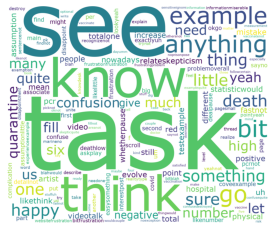

In [22]:
wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
                            stopwords = STOPWORDS,
                            background_color = 'white',
                            width = 1200,
                            height = 1000,
                            ).generate(neg_words_str_vader)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

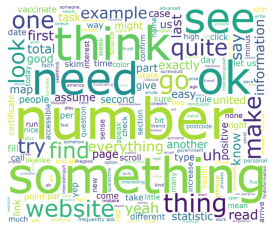

In [23]:
wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
                            stopwords = STOPWORDS,
                            background_color = 'white',
                            width = 1200,
                            height = 1000,
                            ).generate(pos_words_str_vader)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [24]:
# def sentiment_analysis(textfile):
#     with open(textfile) as transcript:
#         lines = transcript.readlines()
#     lines_clean = clean(lines[0])
#     lines_token_stop_pos = token_stop_pos(lines_clean)
#     lines_lemma = lemmatize(lines_token_stop_pos).lower()
#     ngram_object = TextBlob(lines_lemma)
#     ngrams = ngram_object.ngrams(n=3) 
#     for ngram in ngrams:
#         ngram_str = TextBlob(' '.join(ngram))
#         sentiment = ngram_str.sentiment.polarity
#         subjectivity = ngram_str.sentiment.subjectivity
#         # sentiment_vader = analyzer.polarity_scores(ngram_str)
#         if sentiment >= 0.2:
#             print('Ngram: ' + ' '.join(ngram) + ' | sentiment: ' + str(sentiment) + ' | subjectivity: ' + str(subjectivity))
#         if sentiment < 0:
#             print('Ngram: ' + ' '.join(ngram) + ' | sentiment: ' + str(sentiment) + ' | subjectivity: ' + str(subjectivity))
    
# #     file_content=open (textfile).read()

# #     wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
# #                             stopwords = STOPWORDS,
# #                             background_color = 'white',
# #                             width = 1200,
# #                             height = 1000,
# #                             color_func = random_color_func
# #                             ).generate(lines_lemma)
# #     plt.imshow(wordcloud)
# #     plt.axis('off')
# #     plt.show()

In [25]:
# sentiment_analysis("testing_text.txt")

In [26]:
df_azure_speech

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
0,Alright.,alright,0.000000,1.000,0.000,0.000,0.2500,Positive,None
1,"Let's see OK, so Yep, I'll read the test numbe...",let us see ok yep shall read test number one,0.500000,0.592,0.000,0.408,0.7717,Positive,None
2,I think I took more than 122 minutes.,think take 122 minute,0.000000,0.000,0.000,1.000,0.0000,Neutral,None
3,"Uh, what I did is to take a look over the whol...",uh take look whole website get idea like stati...,0.400000,0.217,0.000,0.783,0.3612,Positive,[Satisfaction]
4,"I think it was, can you?",think,0.000000,0.000,0.000,1.000,0.0000,Neutral,None
...,...,...,...,...,...,...,...,...,...
599,It turned off the extension.,turn extension,0.000000,0.000,0.000,1.000,0.0000,Neutral,None
600,I hope that everything was recorded and I wasn...,hope everything record not sure need send anyt...,0.888889,0.267,0.181,0.552,0.2354,Positive,[Expectation]
601,It does that by itself or so.,,0.000000,0.000,0.000,0.000,0.0000,Neutral,None
602,That was also quite interesting.,also quite interesting,0.500000,0.599,0.000,0.401,0.4576,Positive,None


array([[<AxesSubplot:title={'center':'textblob-subjectivity'}>,
        <AxesSubplot:title={'center':'vader-pos'}>],
       [<AxesSubplot:title={'center':'vader-neg'}>,
        <AxesSubplot:title={'center':'vader-neu'}>],
       [<AxesSubplot:title={'center':'vader-compound'}>, <AxesSubplot:>]],
      dtype=object)

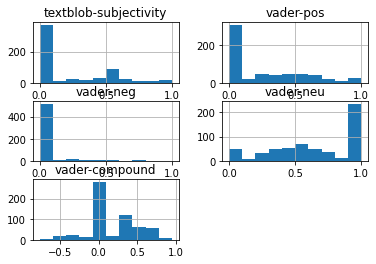

In [27]:
df_azure_speech.hist()

<AxesSubplot:xlabel='vader-polarity', ylabel='vader-compound'>

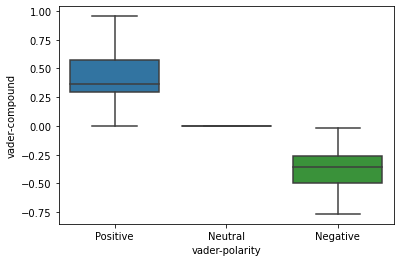

In [28]:
sns.boxplot(data=df_azure_speech, x="vader-polarity", y="vader-compound")

<AxesSubplot:ylabel='vader-polarity'>

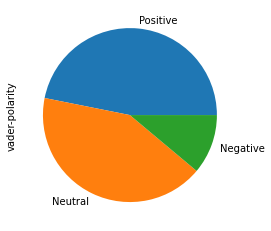

In [29]:
df_azure_speech['vader-polarity'].value_counts().plot(kind='pie')

In [30]:
df_azure_speech.sort_values('vader-compound').head(20)

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
323,Desk that that it destroyed my frustration.,desk destroy frustration,0.000000,0.000,0.868,0.132,-0.7650,Negative,None
194,"For example, it's not like anything that might...",example not like anything might complication c...,0.000000,0.000,0.462,0.538,-0.7193,Negative,[Satisfaction]
190,Something that so before in the on the main pa...,something main page um think number death not ...,0.333333,0.098,0.452,0.451,-0.6917,Negative,[Satisfaction]
560,Then you don't see any so much here because it...,not see much tell go back two fill not ready v...,0.300000,0.000,0.309,0.691,-0.6908,Negative,[Satisfaction]
324,"My frustration level was yeah, I feel that dis...",frustration level yeah feel disappointment web...,0.400000,0.190,0.552,0.259,-0.6369,Negative,None
137,I don't know 1000 people in hospitals and so o...,not know 1000 people hospital not see many exa...,0.500000,0.000,0.383,0.617,-0.6072,Negative,None
107,"One of them has something different, and here ...",one something different not know number like r...,0.429167,0.000,0.454,0.546,-0.5875,Negative,[Satisfaction]
520,Not like to write it by my hand for example.,not like write hand example,0.000000,0.000,0.612,0.388,-0.5773,Negative,[Satisfaction]
575,And I'm not sure if that was the kind of infor...,not sure kind information would,0.894444,0.000,0.612,0.388,-0.5773,Negative,None
593,"Uh, I would have given four or five maybe, but...",uh would give four five maybe couple negative ...,0.400000,0.000,0.270,0.730,-0.5719,Negative,None


In [31]:
df_azure_speech.sort_values('vader-compound', ascending=False).head(20)

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
526,Here like I I think are they like trusting me ...,like think like trust provide good faith right...,0.578571,0.795,0.000,0.205,0.9545,Positive,"[Satisfaction, Satisfaction, Satisfaction]"
79,I only saw like there is positive numbers and ...,saw like positive number something like assume...,0.500337,0.470,0.074,0.455,0.8569,Positive,"[Satisfaction, Satisfaction, Expectation, Sati..."
553,"Why, like you could have said if I want to to ...",like could say want get virtual certificate di...,0.000000,0.478,0.000,0.522,0.8402,Positive,"[Satisfaction, Satisfaction, Satisfaction]"
29,So that was quite fast to see in case someone ...,quite fast see case someone interested would s...,0.550000,0.562,0.000,0.438,0.8393,Positive,None
521,"That's where they've been an option too, and w...",option would make everything also easier not w...,0.000000,0.366,0.051,0.583,0.8214,Positive,None
83,The thing I found Nice is that it was updated ...,thing find nice update like today think,1.000000,0.675,0.000,0.325,0.8074,Positive,[Satisfaction]
278,And then I was lucky to skim through them to f...,lucky skim find second page example like could,0.416667,0.624,0.000,0.376,0.8074,Positive,[Satisfaction]
67,"Yeah, because this was also like a kind of a w...",yeah also like kind way tell,0.900000,0.730,0.000,0.270,0.7964,Positive,[Satisfaction]
68,This is like from the from a government websit...,like government website something like know in...,0.000000,0.615,0.000,0.385,0.7906,Positive,"[Satisfaction, Satisfaction]"
279,It could have made very easy and just by like ...,could make easy like like,0.833333,0.798,0.000,0.202,0.7845,Positive,"[Satisfaction, Satisfaction]"
